In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import importlib
import scalesc as ssc

/edgehpc/dept/compbio/users/hzhang13/envs/scalesc2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_dir = '../data_dir/70k_human_lung'

scalesc = ssc.ScaleSC(data_dir=data_dir, 
                  max_cell_batch=1e4,
                  preload_on_cpu=True, 
                  preload_on_gpu=True, 
                  save_raw_counts=False,
                  save_norm_counts=False,
                  output_dir='test_scalesc_70k_results')

In [3]:
# calculate qc if qc hasn't been performed 
scalesc.calculate_qc_metrics()
print(scalesc.adata.shape)

(65662, 26485)


In [4]:
# filer cells and genes
scalesc.filter_genes(min_count=3)
scalesc.filter_cells(min_count=200, max_count=6000)
print('shape after filtering', scalesc.adata.shape)

shape after filtering (65462, 20901)


In [5]:
# hvg
scalesc.highly_variable_genes(n_top_genes=4000)
scalesc.adata.var[scalesc.adata.var['highly_variable'] == True]

,highly_variable
SAMD11,True
HES4,True
ISG15,True
TTLL10,True
TNFRSF18,True
...,...
ATP6AP1,True
G6PD,True
MPP1,True
F8,True


In [6]:
# normal and log1p 
scalesc.normalize_log1p()

In [7]:
# pca use hvg
scalesc.pca(n_components=50, hvg_var='highly_variable')
print(scalesc.adata[sorted(scalesc.adata.obs_names)].obsm['X_pca'])

[[-4.73349059e+00 -1.12339143e+01 -4.07173119e+00 ... -4.35887206e-02
  -3.89664913e-03 -8.64644670e-01]
 [-3.48735385e+00 -1.20327786e+01 -6.42973460e+00 ... -3.89624373e-01
   1.00712698e-01  2.00979304e-01]
 [ 8.07003875e+00 -4.21509064e+00 -3.58755316e+00 ... -5.32955268e-01
   4.44238922e-01  9.21485501e-01]
 ...
 [ 6.77662671e+00 -4.58966592e+00 -3.74240129e+00 ... -2.60115066e-01
   6.59014185e-01 -1.40978363e+00]
 [-4.66867973e+00 -1.38747469e+01 -7.05540829e+00 ...  6.73499080e-01
  -3.06967140e-01  1.49080368e+00]
 [ 7.39636009e+00 -5.39302853e+00 -4.06548208e+00 ... -1.52833083e-02
  -9.47220655e-01  1.07673014e+00]]


In [8]:
# harmony
scalesc.harmony(sample_col_name='sampleID', max_iter_harmony=10)

2024-11-03 16:24:49,209 - scaleSC - DEBUG - Harmony: Iteration 1 of 10
2024-11-03 16:24:56,289 - scaleSC - DEBUG - Harmony: Iteration 2 of 10
2024-11-03 16:25:03,815 - scaleSC - DEBUG - Harmony: Iteration 3 of 10
2024-11-03 16:25:10,309 - scaleSC - DEBUG - Harmony: Iteration 4 of 10
2024-11-03 16:25:16,566 - scaleSC - INFO - Harmony: Converged after 4 iterations


In [9]:
# neighbors & leiden & umap
scalesc.neighbors(n_neighbors=20, n_pcs=50, use_rep='X_pca_harmony')
scalesc.leiden(resolution=0.5)
scalesc.umap()

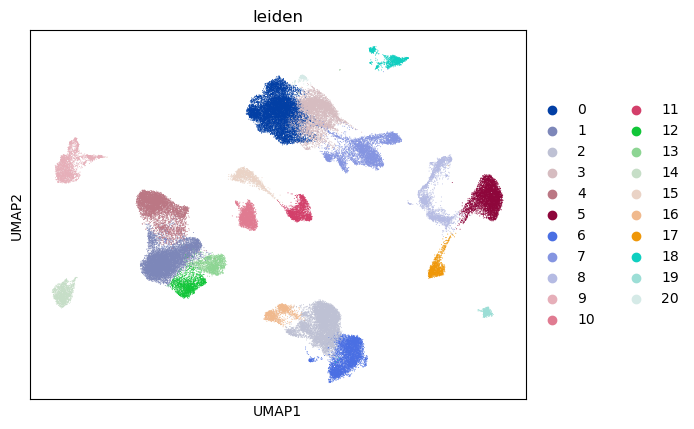

In [10]:
# plot umap
sc.pl.umap(scalesc.adata, color='leiden')

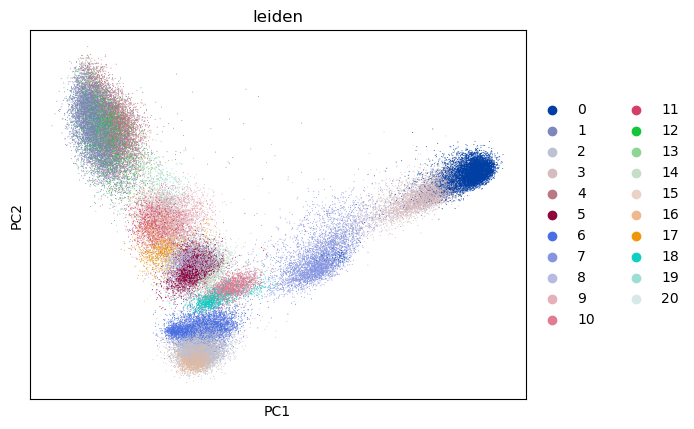

In [11]:
# plot pca
sc.pl.pca(scalesc.adata, color='leiden')

In [12]:
# save adata to disk, note: this adata doesn't contain count matrix 
scalesc.save()

In [13]:
# save normalized count matrix to disk in batches
scalesc.savex(name='norm_counts')

In [14]:
# get merged adata with count matrix, but have to perform it on CPU
scalesc.to_CPU()
adata = scalesc.adata_X
adata.obs['leiden'] = scalesc.adata.obs['leiden']
adata.obsm['X_umap'] = scalesc.adata.obsm['X_umap']

In [15]:
# find marker and refine clusters
cluster_col_after_merge = ssc.adata_cluster_merge(adata, 'leiden')

2024-11-03 16:38:53,645 - scaleSC - DEBUG - Preparing data...
2024-11-03 16:38:53,647 - scaleSC - DEBUG - n_total_clusters: 21
2024-11-03 16:38:53,648 - scaleSC - DEBUG - 0.0018970966339111328 seconds
2024-11-03 16:38:53,648 - scaleSC - DEBUG - Calculating medians...
2024-11-03 16:38:57,606 - scaleSC - DEBUG - Time - calculate_median_sparse_fast_gpu: 3.95719051361084s
2024-11-03 16:38:57,606 - scaleSC - DEBUG - 3.9579732418060303 seconds
2024-11-03 16:38:57,607 - scaleSC - DEBUG - Number of clusters to evaluate: 21
2024-11-03 16:38:58,264 - scaleSC - DEBUG - 1 out of 21:
2024-11-03 16:38:58,264 - scaleSC - DEBUG - 	0
2024-11-03 16:39:02,773 - scaleSC - DEBUG - Time - myXGBClassifier: 4.508133411407471s
2024-11-03 16:39:03,274 - scaleSC - DEBUG - Time - myDecisionTreeEvaluation: 0.482820987701416s
2024-11-03 16:39:03,274 - scaleSC - DEBUG - 	['GPD1', 'ITGB8', 'HLA-DQB2', 'FCGR1A', 'EMC3', 'HP', 'TARP', 'IL1B', 'PCOLCE2', 'PPIC', 'OASL', 'FPR2', 'ERP44', 'LY86', 'LAMP2', 'VSIG4', 'MS4A4A

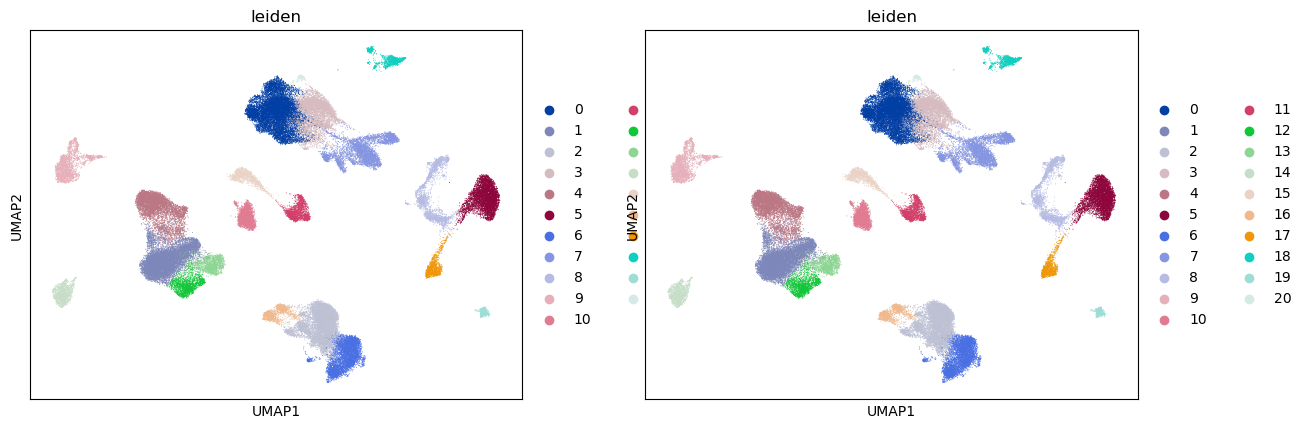

In [16]:
sc.pl.umap(adata, color=['leiden', cluster_col_after_merge])